In [81]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sb
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error

#### 3.2) Neural Networks
- - -

In [82]:
# load previously processed information into dataframe
df = pd.read_csv('data/covid_19_world_processed.csv', delimiter=',')
df
#df.loc[df["Lat_norm"].isna() | df["Long_norm"].isna() | df["Num_days_from_begin_norm"].isna()]

,Country/Region,Lat,Lat_norm,Long,Long_norm,Date,Num_days_from_begin,Num_days_from_begin_norm,Confirmed,Deaths,Recovered
0,Afghanistan,33.000000,0.683333,65.000000,0.680556,2020-01-22,0,0.000000,0,0,0.0
1,Albania,41.153300,0.728629,20.168300,0.556023,2020-01-22,0,0.000000,0,0,0.0
2,Algeria,28.033900,0.655744,1.659600,0.504610,2020-01-22,0,0.000000,0,0,0.0
3,Andorra,42.506300,0.736146,1.521800,0.504227,2020-01-22,0,0.000000,0,0,0.0
4,Angola,-11.202700,0.437763,17.873900,0.549650,2020-01-22,0,0.000000,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
22679,West Bank and Gaza,31.952200,0.677512,35.233200,0.597870,2020-05-07,106,0.990654,375,2,176.0
22680,Western Sahara,24.215500,0.634531,-12.885800,0.464206,2020-05-07,106,0.990654,6,0,5.0
22681,Yemen,15.552727,0.586404,48.516388,0.634768,2020-05-07,106,0.990654,25,5,1.0
22682,Zambia,-15.416700,0.414352,28.283300,0.578565,2020-05-07,106,0.990654,153,4,103.0


In [83]:
# define helper functions
def get_coords_for_country(country):
    country_row = df.loc[df["Country/Region"] == country]
    return country_row["Lat"].unique()[0], country_row["Long"].unique()[0]

get_coords_for_country("Afghanistan")

(33.0, 65.0)

In [84]:
# get the inputs of the data for the machine learning algorithm
inputs = df[["Lat_norm", "Long_norm", "Num_days_from_begin_norm"]].values
inputs

array([[0.683333, 0.680556, 0.      ],
       [0.728629, 0.556023, 0.      ],
       [0.655744, 0.50461 , 0.      ],
       ...,
       [0.586404, 0.634768, 0.990654],
       [0.414352, 0.578565, 0.990654],
       [0.388889, 0.583333, 0.990654]])

#### 3.1.1) Regression for Confirmed Cases
- - -

In [85]:
# get the output for the machine learning algorithm (confirmed cases)
outputs = df["Confirmed"].values
outputs

array([  0,   0,   0, ...,  25, 153,  34])

In [86]:
# split the data into training and testing sets
in_conf_train, in_conf_test, out_conf_train, out_conf_test = train_test_split(inputs, outputs, test_size=0.25, shuffle=False)

print(np.any(np.isnan(in_conf_train)))
print(np.all(np.isfinite(in_conf_train)))
print(np.any(in_conf_train >= np.finfo(np.float64).max))
print()
print(np.any(np.isnan(out_conf_train)))
print(np.all(np.isfinite(out_conf_train)))
print(np.any(out_conf_train >= np.finfo(np.float64).max))

# NOTE: actually, the "testing" set will be used for "manual" testing and plotting, while the training set will be
# further divided in training and testing sets, in order to perform k-fold cross validation.

False
True
False

False
True
False


In [87]:
mlp = MLPRegressor()
mlp.get_params()

{'activation': 'relu',
 'alpha': 0.0001,
 'batch_size': 'auto',
 'beta_1': 0.9,
 'beta_2': 0.999,
 'early_stopping': False,
 'epsilon': 1e-08,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'learning_rate_init': 0.001,
 'max_fun': 15000,
 'max_iter': 200,
 'momentum': 0.9,
 'n_iter_no_change': 10,
 'nesterovs_momentum': True,
 'power_t': 0.5,
 'random_state': None,
 'shuffle': True,
 'solver': 'adam',
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': False,
 'warm_start': False}

In [95]:
# do hyper parameter tuning with the Multi-layer Perceptron, using cross validation
param_grid = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

#grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, n_jobs=-1, cv=3, verbose=2)
#grid_search.fit(in_conf_train, out_conf_train)
#print('Best score: {}'.format(grid_search.best_score_))
#print('Best parameters: {}'.format(grid_search.best_params_))
#grid_search.best_estimator_
#mlp_estimator = grid_search.best_estimator_
mlp_estimator = MLPRegressor(max_iter=1000000)

MAE: 13263.630368301825
MSE: 4954740586.580073


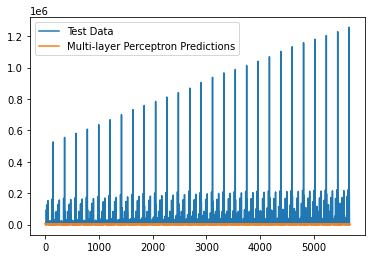

In [96]:
mlp_estimator.fit(in_conf_train, out_conf_train)
mlp_estimator_pred = mlp_estimator.predict(in_conf_test)
plt.plot(out_conf_test)
plt.plot(mlp_estimator_pred)
plt.legend(['Test Data', 'Multi-layer Perceptron Predictions'])
print('MAE:', mean_absolute_error(out_conf_test, mlp_estimator_pred))
print('MSE:', mean_squared_error(out_conf_test, mlp_estimator_pred))